In [2]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import pandas as pd
import pickle as pkl
import random
import torch
import torch.nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from PIL import Image
import util.opt as opt
from util.data import *
from network.net import PConvUNet
from util.image import unnormalize
from collections import OrderedDict
import tensorflow as tf
from tqdm import tqdm

## Read masks

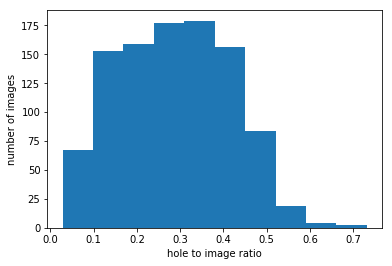

In [2]:
test_csv = pd.read_csv("../dataset/test.csv")
files = test_csv.to_numpy().reshape(-1,)
masks_paths =  ["../dataset/masks/" + file + ".png" for file in files]
masks = [np.array(Image.open(mask_path)) for mask_path in masks_paths]

# compute fill ratio
hole2image = [np.sum(mask == 0) / np.prod(mask.shape) for mask in masks]

# plot histogram
plt.hist(hole2image)
plt.xlabel("hole to image ratio")
plt.ylabel("number of images")
plt.show()

In [3]:
bins = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
disc_hole2image = pd.cut(x=hole2image, bins=bins)
disc_hole2image = [str(x) for x in disc_hole2image]

dict_masks = {}
for i in range(len(masks)):
    dh2i = disc_hole2image[i]
    
    if dh2i == 'nan':
        continue
        
    dict_masks[dh2i] = dict_masks.get(dh2i, []) + [masks[i]]

In [ ]:
ranges = ['(0.01, 0.1]', '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', '(0.5, 0.6]']
values = [len(dict_masks[rng]) for rng in ranges]

plt.bar(ranges, values)
plt.show()

## Compute scores

In [ ]:
def score_func(gts: list, outputs: list, func_name:str):
    scores = []
    sess = tf.Session()
    
    with sess.as_default():
        for i in range(len(gts)):
            gt, output = gts[i], outputs[i]
            num_pixels = float(np.prod(gt.shape))
            
            gt = tf.convert_to_tensor(gt)
            output = tf.convert_to_tensor(output)

            if func_name == 'PSNR':
                score = tf.image.psnr(gt, output, max_val=1.0)
            elif func_name == 'SSIM':
                score = tf.image.ssim(gt, output, max_val=1.0)
            else:
                score = tf.divide(tf.reduce_sum(tf.abs(gt - output)), num_pixels / 255.)

            score = score.eval()
            if score == np.inf:
                continue
            scores.append(score)
            
    return scores

In [ ]:
# dictionary of metric functions
metric_funcs = [ "L1", "PSNR", "SSIM"]

# dictionary of metric scores
metric_scores = {
   '(0.01, 0.1]': OrderedDict(), 
    '(0.1, 0.2]': OrderedDict(), 
    '(0.2, 0.3]': OrderedDict(), 
    '(0.3, 0.4]': OrderedDict(), 
    '(0.4, 0.5]': OrderedDict(), 
    '(0.5, 0.6]': OrderedDict()
}

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create dataset
dataset = NusceneDataset('../dataset', train=False)
dataloader = DataLoader(dataset, batch_size=32, num_workers=1, drop_last=False)

# load model
model = PConvUNet().to(device)
ckpt_dict = torch.load("../snapshots_GAN/ckpt_GAN_alpha_0.75/1000000.pth")
model.load_state_dict(ckpt_dict["model"], strict=False)
model.eval()


for rng in tqdm(dict_masks):
    for i, sample in enumerate(dataloader):#len(dataset)):
        gts = sample["gt"].float().to(device)
        
        # sample a random maks from the current range
        idx = np.random.choice(np.arange(len(dict_masks[rng])), size=gts.shape[0], replace=True)
        masks = [dict_masks[rng][i] for i in idx]
        masks = [np.expand_dims(mask / 255., 0).repeat(3, axis=0) for mask in masks]
        masks = torch.tensor(np.stack(masks)).float().to(device)
        
        # image masked
        imgs = gts * masks
        
        # get output
        with torch.no_grad():
            outputs, _ = model(imgs, masks)
        outputs_comp = masks * imgs + (1 - masks) * outputs
        
        # send back to cpu
        gts = gts.cpu()
        outputs_comp = outputs_comp.cpu()
        
        # unnormalize
        un_gts = unnormalize(gts)
        un_outputs_comp = unnormalize(outputs_comp)
        
        # get them to range 0, 1
        un_gts = torch.clamp(un_gts, 0., 1.)
        un_outputs_comp = torch.clamp(un_outputs_comp, 0., 1.)
        
        # reshape and typing
        un_gts = [x.transpose(1, 2, 0) for x in list(un_gts.numpy())]
        un_outputs_comp = [x.transpose(1, 2, 0) for x in list(un_outputs_comp.numpy())]
        for score_name in metric_funcs:
            metric_scores[rng][score_name] = metric_scores[rng].get(score_name, []) + \
                score_func(un_gts, un_outputs_comp, score_name)
        
        break

In [ ]:
statistics = {}

for rng in tqdm(ranges):
    statistics[rng] = []

    for score_name in metric_funcs:
        statistics[rng].append(np.mean(metric_scores[rng][score_name]))

In [ ]:
results = pd.DataFrame(statistics, index=metric_funcs)
results.to_csv("../results/vanilla_results.csv")

In [12]:
results = pd.read_csv("../results/GAN_beta_100.00_results.csv", index_col=0)
results

,"(0.01, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]","(0.5, 0.6]"
L1,2.272266,8.035231,12.948554,17.407557,21.516500,32.081116
PSNR,27.541391,20.396593,17.993950,16.615774,15.657435,13.263650
SSIM,0.965461,0.884244,0.812185,0.732255,0.663343,0.570515


In [ ]:
results = pd.read_csv("../results/GAN_alpha_0.00_results.csv", index_col=0)
results